# File Info

Point of file is learning $\dot x = f_\theta(x(t), \lambda(t))$

Learning Standard Hopf Bifurcation with static bif parameter was completed in v2 

Moving to dynamic bifurcation parameter, v3 learned with a static evolution. 

In [1]:
from torchdiffeq import odeint as odeint

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider
import types

import Neural_ODEs_v1 as nodes
import DynamicalSystems as ds

ModuleNotFoundError: No module named 'torchdiffeq'

# Data Geneation

Hopf Bifurcation

$\alpha > 0$ for supercritical

$\alpha < 0$ for subcritical

$$ 
\begin{aligned}
\dot r = r (\rho + \alpha r^2) \\
\dot \theta = \omega + \beta r^2
\end{aligned}
$$

fixed points at $r = 0$ and $r = \sqrt{\frac{-\rho}{\alpha}}$


In [2]:
def rho_func(t, r0=-1.0):
    if t < 5.0:
        return r0
    else:
        return r0 + 2.0

In [38]:
class Hopf(ds.DynamicalSystem_torch):
    def __init__(self, rho=lambda t: 1.0, alpha=1.0, omega = 1.0, beta=1.0):
        super().__init__()
        self.rho = rho 
        self.alpha = alpha
        self.beta = beta
        self.omega = omega
        self.gamma = 0.0  # rate of evolution of non-autonomous parameter
        self.system_dim = 2


    def f(self, t, x): 
        #x sould be (traj, dim)
        if not isinstance(x, torch.Tensor):
            raise TypeError(f"Expected torch.Tensor, got {type(x)}")
        elif len(x.shape) == 1:
            if x.shape[0] != self.system_dim: 
                raise ValueError("x must have dimension of 2")
            else:
                x = x.unsqueeze(0)
        elif len(x.shape) == 2: 
            if x.shape[1] != self.system_dim: 
                raise ValueError("x.shape[1] must have dimension of ", self.system_dim)
        else:
            raise ValueError("Input tensor x cannot have more than 2 dimensions (trajectory, dimension)")
        
        xdot = self.rho * x[:, 0] - self.omega * x[:, 1] + (self.alpha*x[:, 0] - self.beta * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #traj
        ydot = self.omega * x[:, 0] + self.rho * x[:, 1] + (self.beta*x[:, 0] + self.alpha * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #(traj)
        return torch.cat([xdot.unsqueeze(1), ydot.unsqueeze(1)], dim = 1)
    
    def na_f(self, t, x):
        if not callable(self.rho):
            raise TypeError(f"Expected callable for non-autonomous parameter rho, got {type(self.rho)}")
        
        xdot = self.rho(t) * x[:, 0] - self.omega * x[:, 1] + (self.alpha*x[:, 0] - self.beta * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #traj
        ydot = self.omega * x[:, 0] + self.rho(t) * x[:, 1] + (self.beta*x[:, 0] + self.alpha * x[:, 1])*(x[:, 0]**2 + x[:, 1]**2) #(traj)

        return torch.cat([xdot.unsqueeze(1), ydot.unsqueeze(1)], dim = 1)

In [39]:
lc = Hopf(rho=rho_func, alpha=-1.0, beta=0.0)
#Supercritical hopf 

In [40]:
y0 = torch.tensor([[1.0, 0.0], [0.0, 1.0], [0.0, 0.0]])
y0.shape

torch.Size([3, 2])

In [41]:
lc.na_f(t = 0, x = y0).shape

torch.Size([3, 2])

In [42]:
sol = odeint(func=lc.na_f, y0=y0, t=torch.arange(0, 10, 0.1), method='rk4')

In [43]:
a = torch.arange(-2.0, 2.0, 0.5); b = torch.arange(-2, 2, 0.5); c = torch.ones_like(a)
ic = torch.cartesian_prod(a, b)  #traj, dim


t_span = (0, 10); dt = 0.05
ic.shape #traj, dim


torch.Size([64, 2])

In [44]:
lc.f = lc.na_f

In [45]:
t_span

(0, 10)

In [46]:
lc.rho = lambda t: rho_func(t, r0=1.0)

In [48]:
r_vals = [1]

In [49]:
list = []
for i in range(len(r_vals)):
    lc.rho = lambda t, r0=r_vals[i]: rho_func(t, r0=r0)
    sol = odeint(func=lc.na_f, y0=ic, t=torch.arange(t_span[0], t_span[1], dt), method='rk4')
    list.append(sol)

sol = torch.cat(list, dim=1)

In [50]:
sol.shape  #(r_vals, time, traj, dim)

torch.Size([200, 64, 2])

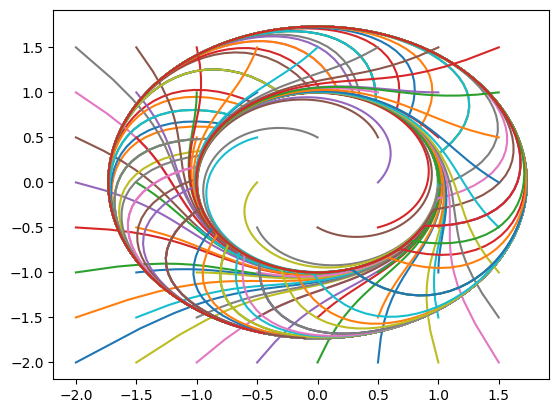

In [53]:
for i in range(ic.shape[0]):
    plt.plot(sol[:, i, 0], sol[:, i, 1])

In [54]:
training_data_tensor = sol.unsqueeze(0)
t_eval_tensor = torch.tensor( np.arange(t_span[0], t_span[1], dt), dtype=torch.float32 ).unsqueeze(0)

In [55]:
print(training_data_tensor.shape, t_eval_tensor.shape)

torch.Size([1, 200, 64, 2]) torch.Size([1, 200])


# Neural ODE - 

In [56]:
class NODE(nodes.Simple_FeedforwardNN):
    '''
    Class that creates an Neural ODE. 
    '''
    def __init__(self, input_dim: int, output_dim: int, depth: int, width: int, activation_func: nn.Module = nn.Tanh()):
        super().__init__(input_dim=input_dim, depth=depth, width=width, output_dim=output_dim, activation_func=activation_func)
        if input_dim < output_dim:
            raise ValueError("Input dimension must be greater than or equal to output dimension in a neural ODE.")
        else:
            self.width              = width #width is number of neurons per hidden layer
            self.depth              = depth #Number of internal hidden layers
            self.input_dim         = input_dim
            self.output_dim        = output_dim
            self.activation_func   = activation_func
    

    


    def forward(self, t, x): #x shoudl be (num_traj, spatial_dim)
        '''Takes t and x as input, where x is a pytorch tensor with shape: [trajectories, dim].'''
        out = self.network(x) #(num_traj, spatial_dim+drivers)
        return out

In [57]:
model = NODE(input_dim=lc.system_dim+1, output_dim=lc.system_dim, depth=5, width=20, activation_func=nn.Tanh())  

In [60]:
def ode_wrapper(t, x, r = lambda t: rho_func(t, r0=1.0)):
    rho_in =torch.ones(x.shape[0], 1)*r(t)
    x_augmented = torch.cat([x, rho_in], dim=1)
    return model(t, x_augmented)

In [61]:
#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()




In [62]:
num_epochs = 500
batch_size = 32
num_batches = 10

for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()

    # Predicting the trajectory
    pred_x_list = []
    for i in range(t_eval_tensor.shape[0]):
        pred_x_temp = odeint(ode_wrapper, training_data_tensor[i, 0, :, :], t_eval_tensor[i, :], method='rk4', options={'step_size': dt})
        pred_x_list.append(pred_x_temp)

    pred_x = torch.stack(pred_x_list, dim=0)

    # Calculating loss
    loss = loss_fn(pred_x, training_data_tensor) 
    loss_list.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

  0%|          | 1/500 [00:00<05:02,  1.65it/s]

Epoch 0, Loss: 2.397515296936035


  4%|▍         | 21/500 [00:12<05:07,  1.56it/s]

Epoch 20, Loss: 1.2048839330673218


  8%|▊         | 41/500 [00:35<10:14,  1.34s/it]

Epoch 40, Loss: 1.035447597503662


 12%|█▏        | 61/500 [01:01<09:45,  1.33s/it]

Epoch 60, Loss: 0.9742936491966248


 16%|█▌        | 81/500 [01:28<09:10,  1.31s/it]

Epoch 80, Loss: 0.9310405254364014


 20%|██        | 101/500 [01:53<08:22,  1.26s/it]

Epoch 100, Loss: 0.8905677199363708


 24%|██▍       | 121/500 [02:17<05:29,  1.15it/s]

Epoch 120, Loss: 0.8377493023872375


 28%|██▊       | 141/500 [02:30<04:00,  1.49it/s]

Epoch 140, Loss: 0.6351524591445923


 32%|███▏      | 161/500 [02:43<03:44,  1.51it/s]

Epoch 160, Loss: 0.5185173153877258


 36%|███▌      | 181/500 [02:57<03:31,  1.51it/s]

Epoch 180, Loss: 0.44786131381988525


 40%|████      | 201/500 [03:10<03:21,  1.48it/s]

Epoch 200, Loss: 0.396541029214859


 44%|████▍     | 221/500 [03:24<02:58,  1.56it/s]

Epoch 220, Loss: 0.35258787870407104


 48%|████▊     | 241/500 [03:42<05:24,  1.25s/it]

Epoch 240, Loss: 0.31277352571487427


 52%|█████▏    | 261/500 [04:08<05:08,  1.29s/it]

Epoch 260, Loss: 0.2756243646144867


 56%|█████▌    | 281/500 [04:34<04:35,  1.26s/it]

Epoch 280, Loss: 0.24080656468868256


 60%|██████    | 301/500 [05:00<04:20,  1.31s/it]

Epoch 300, Loss: 0.20780745148658752


 64%|██████▍   | 321/500 [05:25<03:49,  1.28s/it]

Epoch 320, Loss: 0.17177042365074158


 68%|██████▊   | 341/500 [05:51<03:23,  1.28s/it]

Epoch 340, Loss: 0.12009119987487793


 72%|███████▏  | 361/500 [06:16<02:51,  1.23s/it]

Epoch 360, Loss: 0.06760135293006897


 76%|███████▌  | 381/500 [06:41<02:29,  1.25s/it]

Epoch 380, Loss: 0.05100060999393463


 80%|████████  | 401/500 [07:06<02:04,  1.26s/it]

Epoch 400, Loss: 0.04611941799521446


 84%|████████▍ | 421/500 [07:32<01:44,  1.33s/it]

Epoch 420, Loss: 0.04588513821363449


 88%|████████▊ | 441/500 [07:58<01:14,  1.26s/it]

Epoch 440, Loss: 0.04348330572247505


 92%|█████████▏| 461/500 [08:23<00:48,  1.24s/it]

Epoch 460, Loss: 0.04235661029815674


 96%|█████████▌| 481/500 [08:47<00:23,  1.25s/it]

Epoch 480, Loss: 0.04199168086051941


100%|██████████| 500/500 [09:11<00:00,  1.10s/it]


In [24]:
# Analysis of Trained Model

In [ ]:
model.gamma

Text(0.5, 0, 'Epochs')

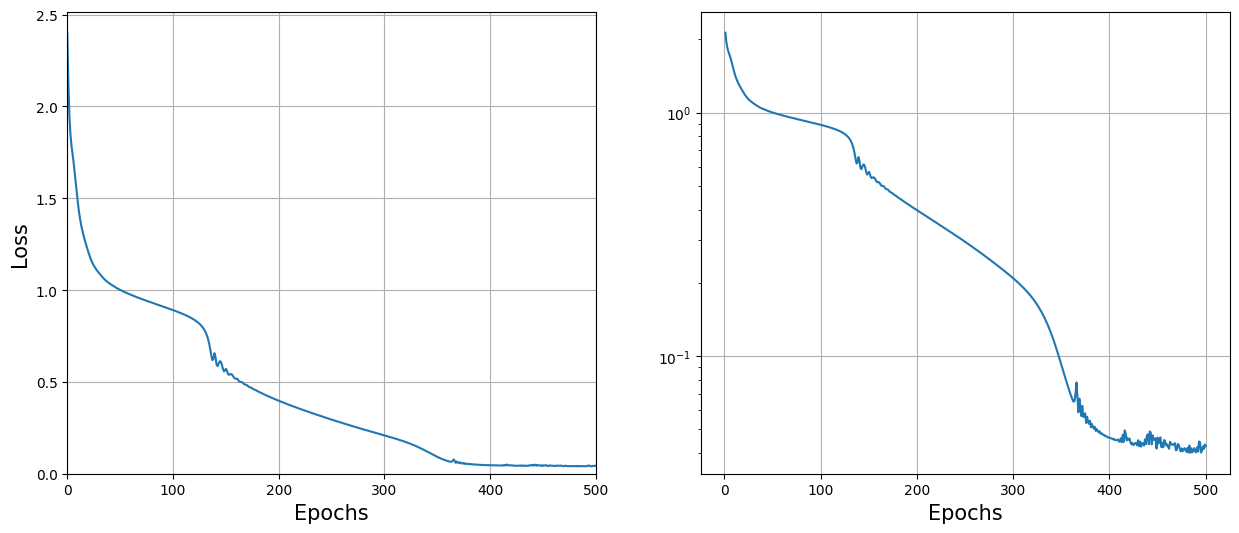

In [63]:
### Analysis  
epochs = len(loss_list)
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])

#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

In [64]:
r_vals = torch.arange(-1.0, 10.0, 0.1)

r_vals.shape

torch.Size([110])

In [66]:
a = torch.linspace(-2, 2, 10)  
b = torch.linspace(-2, 2, 10)  

pts = torch.cartesian_prod(a, b)


t_Start_pred = 0; t_Final_pred = 30; dt_pred = 0.05
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt_pred)
model.gamma = 0.0  # rate of evolution of non-autonomous parameter
node_data = odeint(ode_wrapper, pts.float(), t_eval_pred, method='rk4', options={'step_size': dt_pred})
true_data = odeint(func=lc.na_f, y0=pts, t=t_eval_pred, method='rk4', options={'step_size': dt_pred})

#Plotting results
fig = plt.figure(figsize=(10, 8))

#First Plot
ax1 = fig.add_subplot(1, 2, 1)
for i in range(pts.shape[0]):
    ax1.arrow(x=true_data[0, i, 0].detach().numpy(), y=true_data[0, i, 1].detach().numpy(), 
          dx=true_data[10, i, 0].detach().numpy() - true_data[0, i, 0].detach().numpy(), 
          dy=true_data[10, i, 1].detach().numpy() - true_data[0, i, 1].detach().numpy(), length_includes_head=True, head_width=0.05, head_length=0.1, color='gray')


#ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)


#Second Plot 
ax2 = fig.add_subplot(1, 2, 2)
for i in range(pts.shape[0]):
    ax2.arrow(x=node_data[0, i, 0].detach().numpy(), y=node_data[0, i, 1].detach().numpy(), 
          dx=node_data[10, i, 0].detach().numpy() - node_data[0, i, 0].detach().numpy(), 
          dy=node_data[10, i, 1].detach().numpy() - node_data[0, i, 1].detach().numpy(), length_includes_head=True, head_width=0.05, head_length=0.1, color='gray')

    



plt.show()

In [67]:
node_data.shape

torch.Size([600, 100, 2])

In [34]:
node_data.shape

torch.Size([600, 100, 2])

Text(0.5, 1.0, 'True r(0)=1.0')

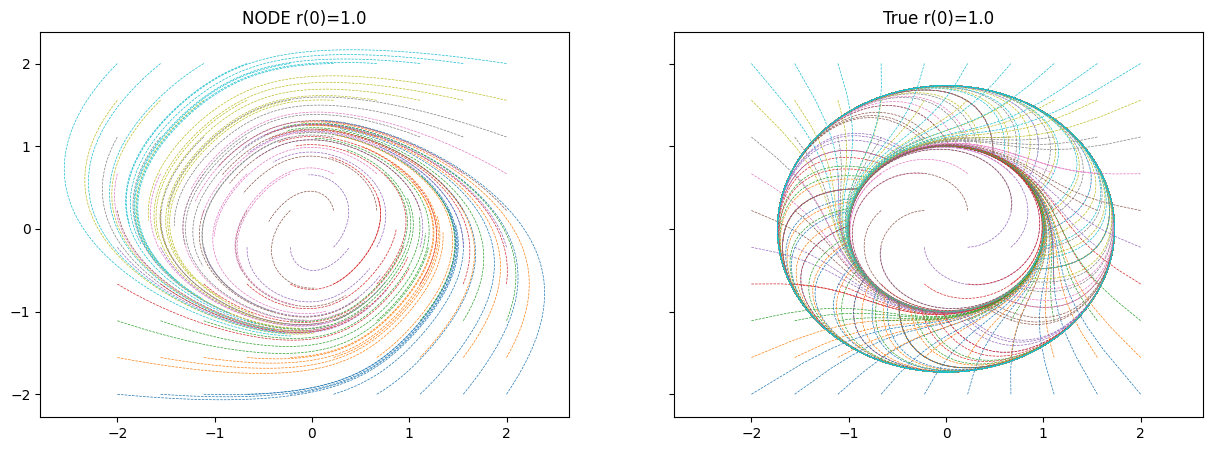

In [76]:

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

#axes[0].plot(node_data[300:, :, 0].detach().numpy(),
#                node_data[300:, :, 1].detach().numpy(),
#                linewidth=0.5, alpha=1, linestyle='--', color='blue')
axes[0].plot(node_data[:50, :, 0].detach().numpy(),
                node_data[:50, :, 1].detach().numpy(),
                linewidth=0.5, alpha=1, linestyle='--')
axes[1].plot(true_data[:, :, 0].detach().numpy(),
                true_data[:, :, 1].detach().numpy(),
                linewidth=0.5, alpha=1, linestyle='--')
axes[0].set_title("NODE r(0)=1.0")
axes[1].set_title("True r(0)=1.0")

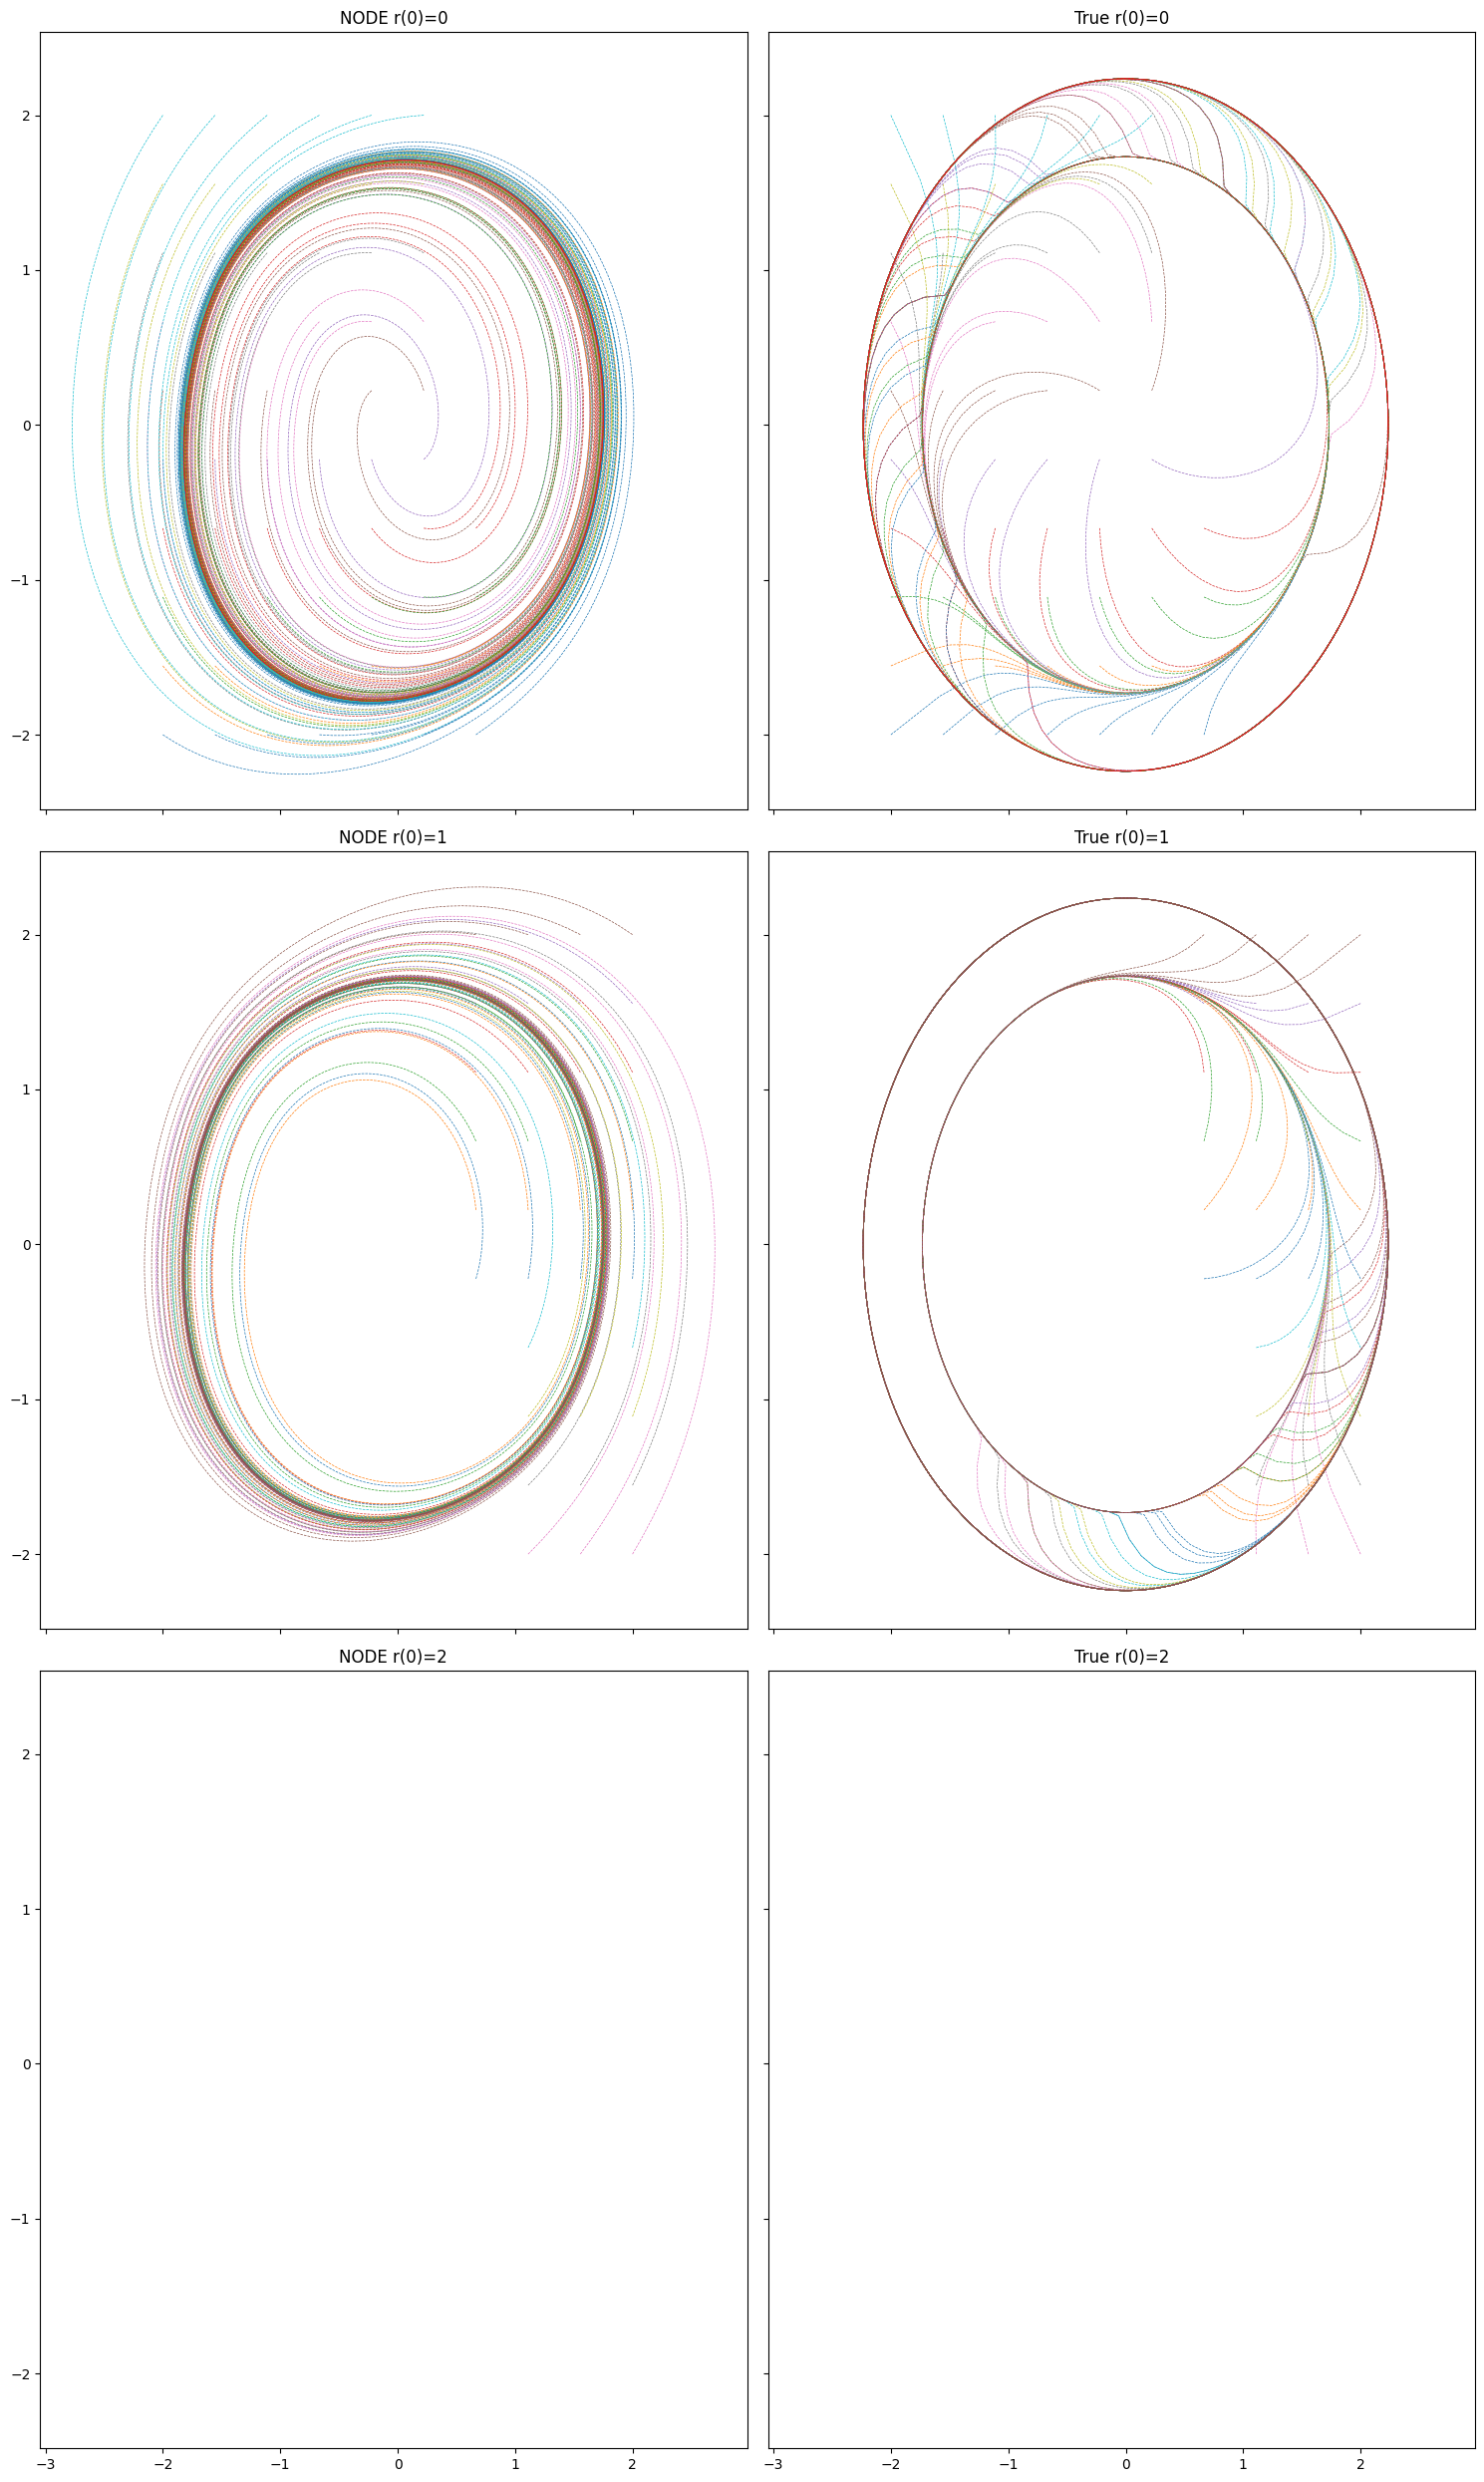

In [ ]:
r_plots = [-1, 1, 3, 5, 7]
fig, axes = plt.subplots(len(r_plots), 2, figsize=(15, 5*len(r_plots)), sharex=True, sharey=True)

for i, r in enumerate(r_plots):
    axes[i, 0].plot(node_data[:, pts[:, 2] == r, 0].detach().numpy(),
                    node_data[:, pts[:, 2] == r, 1].detach().numpy(),
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 1].plot(true_data[:, pts[:, 2] == r, 0].detach().numpy(),
                    true_data[:, pts[:, 2] == r, 1].detach().numpy(),
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 0].set_title(f"NODE r(0)={r}")
    axes[i, 1].set_title(f"True r(0)={r}")

plt.tight_layout()
plt.show()

IndexError: index 2 is out of bounds for dimension 1 with size 2

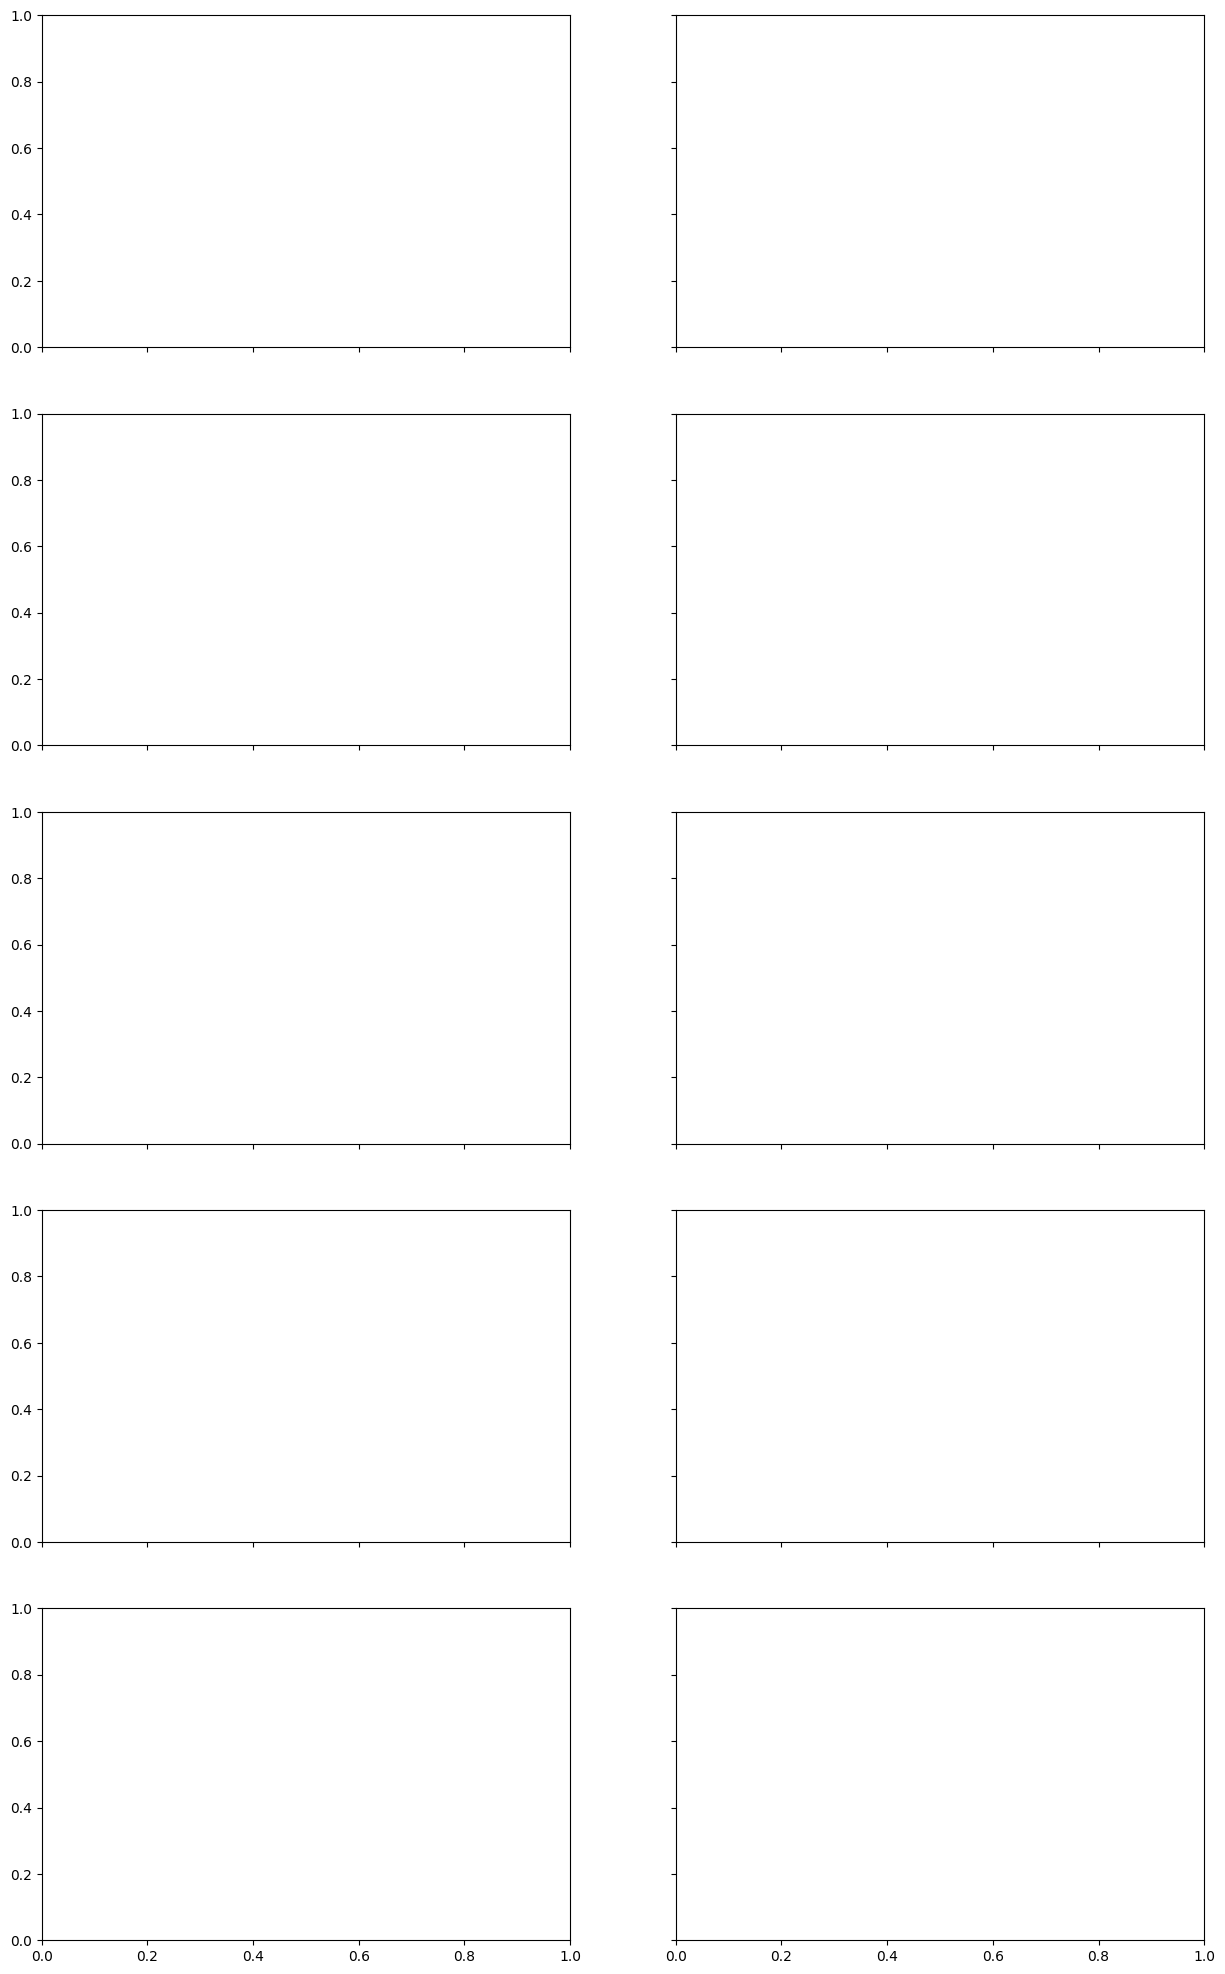

In [30]:
r_plots = [-1, 1, 3, 5, 7]
fig, axes = plt.subplots(len(r_plots), 2, figsize=(15, 5*len(r_plots)), sharex=True, sharey=True)

for i, r in enumerate(r_plots):
    axes[i, 0].plot(node_data[:, pts[:, 2] == r, 0].detach().numpy(),
                    node_data[:, pts[:, 2] == r, 1].detach().numpy(),
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 1].plot(true_data[:, pts[:, 2] == r, 0].detach().numpy(),
                    true_data[:, pts[:, 2] == r, 1].detach().numpy(),
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 0].set_title(f"NODE r(0)={r}")
    axes[i, 1].set_title(f"True r(0)={r}")

plt.tight_layout()
plt.show()

In [39]:
pts.shape

torch.Size([11000, 3])

In [40]:
# Interactive trajectory plot
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt

def plot_traj(idx=0):
    fig = plt.figure(figsize=(15, 8))
    r_val = r_vals[idx]
    print('rho = ', r_val.float())
    #First Plot
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(node_data[:, pts[:, 2] == r_val, 0].detach().numpy(), node_data[:, pts[:, 2] == r_val, 1].detach().numpy(), linewidth=0.5, alpha=1, linestyle='--')

    ax1 = fig.add_subplot(1, 2, 2)
    ax1.plot(true_data[:, pts[:, 2] == r_val, 0].detach().numpy(), true_data[:, pts[:, 2] == r_val, 1].detach().numpy(), linewidth=0.5, alpha=1, linestyle='--')


In [41]:
interact(plot_traj, idx=IntSlider(min=0.0, max=r_vals.shape[0]-1, step=1))

interactive(children=(IntSlider(value=0, description='idx', max=109), Output()), _dom_classes=('widget-interac…

<function __main__.plot_traj(idx=0)>